In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms

from m2_ovo_mae.models.classifier import ViTClassifier
from m2_ovo_mae.models.mae import mae_vit_lite_patch4


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(2000)

/Users/leo/projects/m2-ovo-mae/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MAE Core Methods Demonstration
This notebook demonstrates the core components of the Masked Autoencoder (MAE) architecture:
1. Patchify: Splitting an image into non-overlapping patches.
2. Random Masking: Randomly removing a large portion (e.g., 75%) of the patches.
3. Unpatchify: Reassembling patches back into an image.


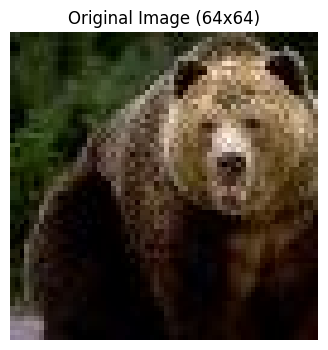

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
# We load the version of the model we trained with, see the report for details on the hyperparameters.
model = mae_vit_lite_patch4(norm_pix_loss=True).to(device)
model.eval()

# We load an image from Tiny ImageNet test set
img_path = "../data/tiny-imagenet-200/test/images/test_6218.JPEG"
img = Image.open(img_path).convert("RGB")

# We apply the same transformations as during training,
# - Making sure the image is 64x64
# - Normalizing with the same mean and std used for training
TIN_MEAN = [0.485, 0.456, 0.406]
TIN_STD = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=TIN_MEAN, std=TIN_STD),
    ]
)

img_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 64, 64]


def show_image(tensor, title=None):
    """Displays a PyTorch tensor as an image, handling denormalization.

    Args:
        tensor (torch.Tensor): Image tensor of shape (1, 3, H, W) or (3, H, W).
        title (str, optional): Title for the plot.
    """
    if tensor.ndim == 4:
        tensor = tensor.squeeze(0)

    # To show the image, we reverse the normalization
    mean = torch.tensor(TIN_MEAN).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(TIN_STD).view(3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean

    img = tensor.cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")


plt.figure(figsize=(4, 4))
show_image(img_tensor, "Original Image (64x64)")
plt.show()

## 2. Patchify
In MAE, the image is first split into $P \times P$ patches. For ViT-Lite on Tiny ImageNet, we use $4 \times 4$ patches.
This results in $(64/4) \times (64/4) = 16 \times 16 = 256$ patches. Each patch has $4 \times 4 \times 3 = 48$ values.


Image shape: torch.Size([1, 3, 64, 64])
Patches shape (N, L, D): torch.Size([1, 256, 48])


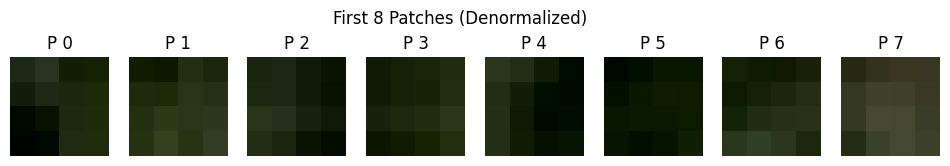

In [3]:
# Patchify the image
patches = model.patchify(img_tensor)
print(f"Image shape: {img_tensor.shape}")
print(f"Patches shape (N, L, D): {patches.shape}")

# Visualize some patches
n_show = 8
fig, axes = plt.subplots(1, n_show, figsize=(12, 2))
p_size = 4
mean = torch.tensor(TIN_MEAN).view(1, 1, 3).to(device)
std = torch.tensor(TIN_STD).view(1, 1, 3).to(device)

for i in range(n_show):
    # Reshape patch and denormalize
    patch = patches[0, i].reshape(p_size, p_size, 3)
    patch = patch * std + mean
    patch = patch.cpu().numpy()
    patch = np.clip(patch, 0, 1)
    axes[i].imshow(patch)
    axes[i].axis("off")
    axes[i].set_title(f"P {i}")
plt.suptitle("First 8 Patches (Denormalized)")
plt.show()

## 3. Random Masking
MAE masks a high percentage of patches (typically 75%, like in our training case). Only the remaining 25% (visible patches) are sent through the encoder.

We emphasize that the encoder receiving only the visible patches is highly beneficial in this context: it reduces a lot the sequence length of the encoder transformer. The time and space complexity (without FlashAttention) of the attention mechanism is quadratic in the sequence length, so reducing the number of patches from 256 to 64 significantly reduces the computational and memory load. This is especially interesting in this self-supervised context where we are less prone to overfitting: we can train a larger model for longer with a reduced wall-clock time.


Masked sequence shape (N, L_keep, D): torch.Size([1, 64, 48])
Mask shape (N, L): torch.Size([1, 256])


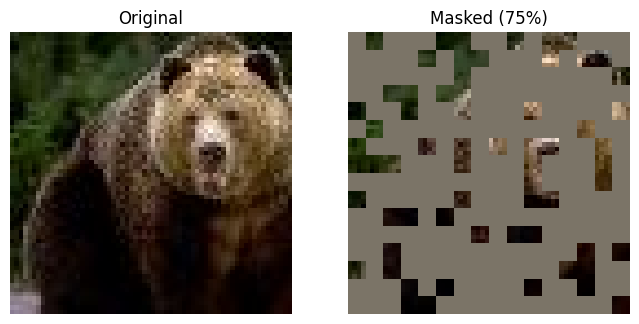

In [4]:
mask_ratio = 0.75
x_masked, mask, ids_restore = model.random_masking(patches, mask_ratio)

print(f"Masked sequence shape (N, L_keep, D): {x_masked.shape}")
print(f"Mask shape (N, L): {mask.shape}")

# To visualize the masked image, we can use the mask to zero out patches in the original sequence
patches_masked = patches.clone()
# mask is 1 for removed patches, 0 for kept.
# We want to multiply by (1 - mask) to keep 0s and zero out 1s.
patches_masked[0, mask[0].bool()] = 0

img_masked = model.unpatchify(patches_masked)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
show_image(img_tensor, "Original")
plt.subplot(1, 2, 2)
show_image(img_masked, f"Masked ({int(mask_ratio * 100)}%)")
plt.show()

## 4. Reassembling (Unpatchify)
The `unpatchify` method is the inverse of `patchify`. It takes the flattened patches and reconstructs the image grid.


Reconstruction mean absolute difference: 0.000000


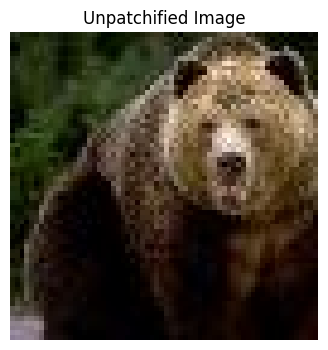

In [5]:
# Verify that unpatchify(patchify(img)) == img
reconstructed = model.unpatchify(patches)
diff = torch.abs(img_tensor - reconstructed).mean().item()
print(f"Reconstruction mean absolute difference: {diff:.6f}")

plt.figure(figsize=(4, 4))
show_image(reconstructed, "Unpatchified Image")
plt.show()

## 5. Reconstruction Visualization
Now let's load a pre-trained checkpoint and see how well the model can actually reconstruct the masked areas.


Loaded checkpoint from ../outputs/2026-02-06/19-41-41/checkpoint-1199.pth


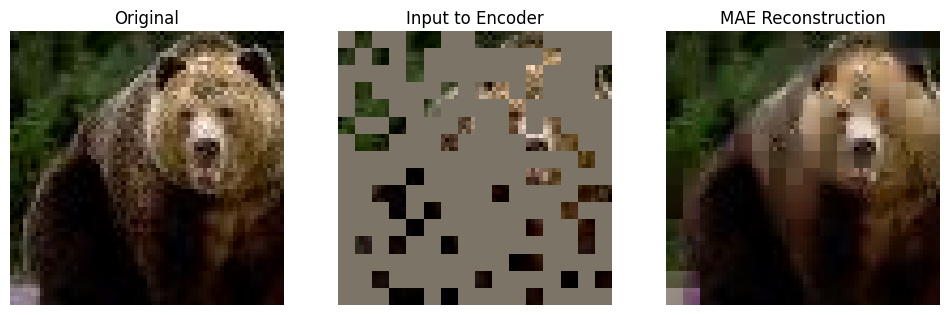

In [6]:
# To illustrate the reconstruction, we load the weights of the last epoch during our pretraining (1200th epoch)
ckpt_path = "../outputs/2026-02-06/19-41-41/checkpoint-1199.pth"
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded checkpoint from {ckpt_path}")

# Run forward pass
with torch.no_grad():
    loss, pred, mask = model(img_tensor, mask_ratio=0.75)

# Per-patch pixel normalization like in the paper:
# The model can be trained to predict normalized pixel values where the target
# for each patch is normalized by its own mean and standard deviation.
# This "enhances the contrast locally" and has been shown to improve
# representation quality for downstream tasks.
if model.norm_pix_loss:
    patches_orig = model.patchify(img_tensor)
    mean = patches_orig.mean(dim=-1, keepdim=True)
    var = patches_orig.var(dim=-1, keepdim=True)
    pred = pred * (var + 1.0e-6) ** 0.5 + mean

# Unpatchify the prediction
# pred is (N, L, p*p*3)
reconstructed_pred = model.unpatchify(pred)

# Visualize: Original, Masked, Reconstructed
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
show_image(img_tensor, "Original")

plt.subplot(1, 3, 2)
# Create masked image for visualization
patches_orig = model.patchify(img_tensor)
patches_masked = patches_orig.clone()
patches_masked[0, mask[0].bool()] = 0
img_masked = model.unpatchify(patches_masked)
show_image(img_masked, "Input to Encoder")

plt.subplot(1, 3, 3)
# Combine visible patches from original and predicted patches for masked areas
patches_reconstructed = patches_orig.clone()
patches_reconstructed[0, mask[0].bool()] = pred[0, mask[0].bool()]
img_final = model.unpatchify(patches_reconstructed)
show_image(img_final, "MAE Reconstruction")

plt.show()

## 6. Classification Inference
Finally, let's load a classifier trained on top of the pre-trained encoder (either via Linear Probing or Fine-tuning).



In [7]:
def load_classifier(ckpt_path, finetune=False):
    """Loads a pre-trained classifier from a checkpoint.

    Args:
        ckpt_path (str): Path to the classification checkpoint.
        finetune (bool, optional): Whether the model was fine-tuned.

    Returns:
        ViTClassifier: The loaded classifier model.
    """
    # Instantiate same encoder architecture
    encoder = mae_vit_lite_patch4(norm_pix_loss=True).to(device)
    classifier = ViTClassifier(encoder, num_classes=200, finetune=finetune).to(device)

    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    classifier.load_state_dict(checkpoint["model_state_dict"])
    classifier.eval()
    return classifier


def get_tin_labels(root_dir):
    """Creates a mapping from class index to human-readable names for Tiny ImageNet.

    Args:
        root_dir (str): Path to the 'tiny-imagenet-200' directory.

    Returns:
        dict: Mapping from index (int) to description (str).
    """
    root_path = Path(root_dir)
    train_dir = root_path / "train"
    wnids = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])

    wnid_to_words = {}
    with open(root_path / "words.txt") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                wnid_to_words[parts[0]] = parts[1]

    idx_to_label = {i: wnid_to_words.get(wnid, wnid) for i, wnid in enumerate(wnids)}
    return idx_to_label


labels = get_tin_labels("../data/tiny-imagenet-200")

# We load the fine-tuned model
classifier_ft = load_classifier(
    "../outputs/finetune_1199/checkpoint-best-clf.pth", finetune=True
)

# Predictions
with torch.no_grad():
    logits = classifier_ft(img_tensor)
    probs = torch.softmax(logits, dim=1)
    top5_probs, top5_indices = torch.topk(probs, 5)

print("Top 5 Predictions:")
for i in range(5):
    idx = top5_indices[0, i].item()
    prob = top5_probs[0, i].item()
    label = labels.get(idx, f"Class {idx}")
    print(f"{prob:.4f} Class {idx}: {label}")

Top 5 Predictions:
0.9994 Class 35: brown bear, bruin, Ursus arctos
0.0002 Class 54: orangutan, orang, orangutang, Pongo pygmaeus
0.0001 Class 58: lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
0.0001 Class 51: bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis
0.0001 Class 169: vestment


The model correctly identifies the image as a brown bear.


## 7. Generalization
We can of course use the model on other images, for example I tested here the reconstruction and classification on the image of my cat.


Loaded local image from ../data/div_pics/cat.jpeg


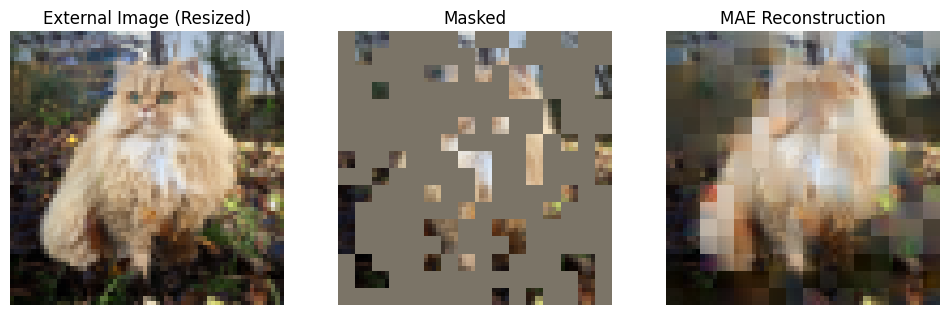

In [8]:
local_cat_path = "../data/div_pics/cat.jpeg"
ext_img = Image.open(local_cat_path).convert("RGB")
print(f"Loaded local image from {local_cat_path}")

ext_tensor = transform(ext_img).unsqueeze(0).to(device)

with torch.no_grad():
    _, ext_pred, ext_mask = model(ext_tensor, mask_ratio=0.75)

if model.norm_pix_loss:
    p_orig = model.patchify(ext_tensor)
    m = p_orig.mean(dim=-1, keepdim=True)
    v = p_orig.var(dim=-1, keepdim=True)
    ext_pred = ext_pred * (v + 1.0e-6) ** 0.5 + m

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(ext_img.resize((64, 64)))
plt.title("External Image (Resized)")
plt.axis("off")

plt.subplot(1, 3, 2)
p_orig = model.patchify(ext_tensor)
p_masked = p_orig.clone()
p_masked[0, ext_mask[0].bool()] = 0
show_image(model.unpatchify(p_masked), "Masked")

plt.subplot(1, 3, 3)
p_recon = p_orig.clone()
p_recon[0, ext_mask[0].bool()] = ext_pred[0, ext_mask[0].bool()]
show_image(model.unpatchify(p_recon), "MAE Reconstruction")
plt.show()

The result isn't bad, except for the eyes; in general our model seem to miss a lot more details compared to the original paper, which could probably be explained mainly by the fact that we trained on Tiny ImageNet's smaller 64x64 images compared to the 224x224 images of ImageNet. The model still captures the general shape and color of my cat, but finer details are lost.


### 7.1 External Image Classification
Now let's see how the fine-tuned classifier labels this external image.


In [9]:
with torch.no_grad():
    ext_logits = classifier_ft(ext_tensor)
    ext_probs = torch.softmax(ext_logits, dim=1)
    ext_top5_probs, ext_top5_indices = torch.topk(ext_probs, 5)

print("Top 5 Predictions for External Image:")
for i in range(5):
    idx = ext_top5_indices[0, i].item()
    prob = ext_top5_probs[0, i].item()
    label = labels.get(idx, f"Class {idx}")
    print(f"{prob:.4f} Class {idx}: {label}")

Top 5 Predictions for External Image:
0.8319 Class 31: Persian cat
0.0742 Class 29: standard poodle
0.0242 Class 49: ox
0.0159 Class 34: lion, king of beasts, Panthera leo
0.0090 Class 35: brown bear, bruin, Ursus arctos


Once again the model correctly identifies the image as a persian cat, although in this case it is less "sure" about it, attributing some weight to the "standard poodle" class as well among others.